# REPORT CONFIGURATION
This section should be populated with the following values:
* Query - The JIRA JQL query to identify the relevant scope
* Title - A description of the scope to include in the reports.
* Days to Extrapolate - For forecasting completion & creation rates, how much historically data should be considered.  Generally, data should be considered in 7-day blocks to avoid any weekend bias.
* Start Dates - The first date to include in reports.
* End Dates - The last date to include in reports.  This date can be future dated.  All dates beyond the current date will be based on extrapolation.

In [83]:
jira_reconnect = False # You will only be prompted to connect the first time.  If credentials are entered incorrectly, you can change this to true to reconnect.
start_date = "2024-08-01"
end_date = "2024-10-29"
days_to_extrapolate = 0

# query = "resolutiondate >= -90d and project != IP"
# title = "All Resolved Tickets"

# query = 'filter=10442'
# title = 'Operator Success'

query = "filter=10444"
title = "Payment Capture"

#query = "filter=10443"
#title = "Pilot Success"

# query = "filter=10284"
# title = "Pilotbase"

# query = "project = FSP and updateddate >= -180d "
# title = "All FSP"

# query = "project in (WEB, FSP, PWD, LTP, IOS, CACCT) and (createddate >= -90d or resolutiondate >= -90d) "
# title = "All Engineering"


# SETUP CONNECTIONS AND CONFIGURATION

In [84]:
# Dependency install and import  -- do both pip and pip3 to avoid issues.
%reload_ext autoreload
%autoreload 2

!pip -q install jira 
!pip3 -q install jira
!pip -q install tqdm
!pip3 -q install tqdm
!pip -q install matplotlib
!pip3 -q install matplotlib
!pip -q install pandas
!pip3 -q install pandas
!pip -q install scikit-learn
!pip3 -q install scikit-learn
!pip -q install plotly
!pip3 -q install plotly


from jira import JIRA
import pandas as pd
import datetime
from datetime import *
from tqdm import tqdm
import time
import getpass
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from IPython import get_ipython


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



In [85]:
# Jira Connection
from jira_fsp_extracts import jira_connect

j = None if 'j' not in globals() else j
j = jira_connect(prompt_for_reconnect = jira_reconnect, existing_connection = j)

In [86]:
# REFERENCE VALUES
from jira_references import *

# SUPPORT FUNCTIONS

In [87]:
# def generate_burndown_chart() # GENERATE A BURNDOWN CHART WITH TOTAL SCOPE, RESOLVED SCOPE, REMAINING SCOPE
def generate_burndown_chart(df, start_date=None, end_date=None, extrapolate_days=None, title=None):
    """
    Generate a burndown chart from a DataFrame containing Jira issue data.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'Created Date', 'Resolution Date', and 'Status'.

    Returns:
    None: Displays the burndown chart.
    """

    # Set the start and end date for the burndown chart
    if start_date is None:
        start_date = df['Created Date'].min()
    else: 
        start_date = pd.to_datetime(start_date).tz_localize(None)

    if end_date is None:
        end_date = df['Resolution Date'].max()
    else: 
        end_date = pd.to_datetime(end_date).tz_localize(None)
  
    # Ensure both start_date and end_date are timezone-naive (or have the same timezone)
    if start_date.tzinfo is not None:
        start_date = start_date.tz_convert(None)
    if end_date.tzinfo is not None:
        end_date = end_date.tz_convert(None)
        
    now = pd.Timestamp('now').normalize()
    
    if title is None:
        title = 'Burndown Chart'
        
    # Create a date range
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a DataFrame to hold the burndown data
    burndown_data = pd.DataFrame(date_range, columns=['Date'])
    burndown_data['Total Tasks'] = 0
    burndown_data['Remaining Tasks'] = 0
    burndown_data['Resolved Tasks'] = 0

    # Initialize extrapolation values
    daily_resolution_rate = None
    daily_creation_rate = None

    # Calculate the number of tasks remaining on each date
    for i, row in burndown_data.iterrows():
        date = row['Date']
        
        if date <= now:
            # prior to today we have actuals
            total_tasks = df[(df['Created Date'] <= date)].shape[0]
            resolved_tasks = df[(df['Resolution Date'] <= date)].shape[0]
            remaining_tasks = total_tasks - resolved_tasks
            
            burndown_data.at[i, 'Total Tasks'] = total_tasks
            burndown_data.at[i, 'Remaining Tasks'] = remaining_tasks
            burndown_data.at[i, 'Resolved Tasks'] = resolved_tasks
            burndown_data.at[i, 'Total Tasks (F)'] = None
            burndown_data.at[i, 'Remaining Tasks (F)'] = None
            burndown_data.at[i, 'Resolved Tasks (F)'] = None
        else:
            # Extrapolate future data if extrapolate_days is provided
            burndown_data.at[i, 'Total Tasks'] = None
            burndown_data.at[i, 'Remaining Tasks'] = None
            burndown_data.at[i, 'Resolved Tasks'] = None
            burndown_data.at[i, 'Total Tasks (F)'] = None
            burndown_data.at[i, 'Remaining Tasks (F)'] = None
            burndown_data.at[i, 'Resolved Tasks (F)'] = None
            
            if extrapolate_days is not None:
                # Calculate the trajectories the first time
                if daily_resolution_rate is None or daily_creation_rate is None:           
                    # Calculate the trajectory based on the last "X" days
                    trajectory_period = min(extrapolate_days, len(date_range))
                    recent_data = burndown_data[(burndown_data['Date'] <= now)].tail(trajectory_period)
                    
                    daily_resolution_rate = recent_data['Resolved Tasks'].diff().mean()
                    daily_creation_rate = recent_data['Total Tasks'].diff().mean()
                    print(f"Extrapolated outcomes based on {trajectory_period} days")
                    print(f"-- Daily Resolution Rate: {round(daily_resolution_rate,2)}")
                    print(f"-- Daily Creation Rate: {round(daily_creation_rate,2)}")
                    
                    burndown_data.at[i-1, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks']
                    burndown_data.at[i-1, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Remaining Tasks']
                    burndown_data.at[i-1, 'Resolved Tasks (F)'] = burndown_data.at[i-1, 'Resolved Tasks']

                        
                burndown_data.at[i, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] + daily_creation_rate
                burndown_data.at[i, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Remaining Tasks (F)'] + daily_creation_rate - daily_resolution_rate
                burndown_data.at[i, 'Resolved Tasks (F)'] = burndown_data.at[i-1, 'Resolved Tasks (F)'] + daily_resolution_rate
            


    # Plot the burndown chart
    plt.figure(figsize=(10, 4))
    plt.plot(burndown_data['Date'], burndown_data['Total Tasks'], color='red', linestyle='-', label='Total Tasks')
    plt.plot(burndown_data['Date'], burndown_data['Remaining Tasks'], color='orange', linestyle='-', label='Remaining Tasks')
    plt.plot(burndown_data['Date'], burndown_data['Resolved Tasks'], color='green', linestyle='-', label='Resolved Tasks')

    if extrapolate_days is not None and (daily_resolution_rate is not None or daily_creation_rate is not None):
        if not burndown_data['Total Tasks (F)'].isna().all:
            plt.plot(burndown_data['Date'], burndown_data['Total Tasks (F)'], color='red', linestyle='dashed')
        if not burndown_data['Remaining Tasks (F)'].isna().all:
            plt.plot(burndown_data['Date'], burndown_data['Remaining Tasks (F)'], color='orange', linestyle='dashed')
        if not burndown_data['Resolved Tasks (F)'].isna().all:
            plt.plot(burndown_data['Date'], burndown_data['Resolved Tasks (F)'], color='green', linestyle='dashed')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Tickets')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    #plt.tight_layout()
    plt.show()

In [88]:
# def generate_stacked_bar_chart() # GENERATE A CHART WITH TOTAL SCOPE BROKEN DOWN BY STATUS
def generate_stacked_bar_chart(df, start_date=None, end_date=None, extrapolate_days=None, title=None):
    """
    Generate a stacked bar chart based on statuses over time.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'Created Date', 'Resolution Date', and 'Status'.

    Returns:
    None: Displays the burndown chart.
    """

    # Set the start and end date for the burndown chart
    if start_date is None:
        start_date = df['Created Date'].min()
    else: 
        start_date = pd.to_datetime(start_date).tz_localize(None)

    if end_date is None:
        end_date = df['Resolution Date'].max()
    else: 
        end_date = pd.to_datetime(end_date).tz_localize(None)
  
    # Ensure both start_date and end_date are timezone-naive (or have the same timezone)
    if start_date.tzinfo is not None:
        start_date = start_date.tz_convert(None)
    if end_date.tzinfo is not None:
        end_date = end_date.tz_convert(None)
        
    now = pd.Timestamp('now').normalize() + pd.Timedelta(days=1)
    
    if title is None:
        title = 'Stacked Bar Status Chart'
        
    # Create a date range
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a DataFrame to hold the burndown data
    burndown_data = pd.DataFrame(date_range, columns=['Date'])
    burndown_data['Total Tasks'] = 0
    burndown_data['PM Backlog Tasks'] = 0
    burndown_data['Eng Backlog Tasks'] = 0
    burndown_data['In Development Tasks'] = 0
    burndown_data['In Validation Tasks'] = 0
    burndown_data['Done Tasks'] = 0

    # Initialize extrapolation values
    daily_resolution_rate = None
    daily_creation_rate = None

    # Calculate the number of tasks remaining on each date
    for i, row in burndown_data.iterrows():
        date = row['Date']
        
        if date <= now:
            # prior to today we have actuals
            total_tasks = df[(df['Created Date'] <= date)].shape[0]
            done_tasks = df[(df['Done Date'] <= date)].shape[0] 
            in_validation_tasks = df[(df['Validation Date'] <= date) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            in_development_tasks = df[(df['Development Date'] <= date) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            eng_backlog_tasks = df[(df['Eng Backlog Date'] <= date) & ((df['Development Date'].isna()) | (df['Development Date'] > date)) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            pm_backlog_tasks = df[(df['PM Backlog Date'] <= date) & ((df['Eng Backlog Date'].isna()) | (df['Eng Backlog Date'] > date)) & ((df['Development Date'].isna()) | (df['Development Date'] > date)) & ((df['Validation Date'].isna()) | (df['Validation Date'] > date)) & ((df['Done Date'].isna()) | (df['Done Date'] > date))].shape[0] 
            #pm_backlog_tasks = total_tasks - done_tasks - in_validation_tasks - in_development_tasks - eng_backlog_tasks
            
            burndown_data.at[i, 'Total Tasks'] = total_tasks
            burndown_data.at[i, 'PM Backlog Tasks'] = pm_backlog_tasks
            burndown_data.at[i, 'Eng Backlog Tasks'] = eng_backlog_tasks
            burndown_data.at[i, 'In Development Tasks'] = in_development_tasks
            burndown_data.at[i, 'In Validation Tasks'] = in_validation_tasks
            burndown_data.at[i, 'Done Tasks'] = done_tasks
            burndown_data.at[i, 'Total Tasks (F)'] = None
            burndown_data.at[i, 'Done Tasks (F)'] = None
            burndown_data.at[i, 'Remaining Tasks (F)'] = None
        else:
            # Extrapolate future data if extrapolate_days is provided
            burndown_data.at[i, 'Total Tasks'] = None
            burndown_data.at[i, 'PM Backlog Tasks'] = None
            burndown_data.at[i, 'Eng Backlog Tasks'] = None
            burndown_data.at[i, 'In Development Tasks'] = None
            burndown_data.at[i, 'In Validation Tasks'] = None
            burndown_data.at[i, 'Done Tasks'] = None
            burndown_data.at[i, 'Total Tasks (F)'] = None
            burndown_data.at[i, 'Done Tasks (F)'] = None
            burndown_data.at[i, 'Remaining Tasks (F)'] = None
            
            if extrapolate_days is not None:
                # Calculate the trajectories the first time
                if daily_resolution_rate is None or daily_creation_rate is None:           
                    # Calculate the trajectory based on the last "X" days
                    trajectory_period = min(extrapolate_days, len(date_range))
                    recent_data = burndown_data[(burndown_data['Date'] <= now)].tail(trajectory_period)
                    
                    daily_resolution_rate = recent_data['Done Tasks'].diff().mean()
                    daily_creation_rate = recent_data['Total Tasks'].diff().mean()
                    print(f"Extrapolated outcomes based on {trajectory_period} days")
                    print(f"-- Daily Resolution Rate: {round(daily_resolution_rate,2)}")
                    print(f"-- Daily Creation Rate: {round(daily_creation_rate,2)}")
                    
                    burndown_data.at[i-1, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks']
                    burndown_data.at[i-1, 'Done Tasks (F)'] = burndown_data.at[i-1, 'Done Tasks']
                    burndown_data.at[i-1, 'Remaining Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] - burndown_data.at[i-1, 'Done Tasks (F)']
            
                burndown_data.at[i, 'Total Tasks (F)'] = burndown_data.at[i-1, 'Total Tasks (F)'] + daily_creation_rate
                burndown_data.at[i, 'Done Tasks (F)'] = burndown_data.at[i-1, 'Done Tasks (F)'] + daily_resolution_rate
                if burndown_data.at[i, 'Done Tasks (F)'] < 0:
                    burndown_data.at[i, 'Done Tasks (F)'] = 0
                burndown_data.at[i, 'Remaining Tasks (F)'] = burndown_data.at[i, 'Total Tasks (F)'] - burndown_data.at[i, 'Done Tasks (F)']

    # For troubleshooting
    burndown_data.to_csv("burndown_data.csv")
    
    # Plot the burndown chart
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(burndown_data['Date'], burndown_data['Total Tasks'], color='black', linestyle='-', label='Total')

    # Plot the stacked bars
    ax.bar(burndown_data['Date'], burndown_data['PM Backlog Tasks'], label='PM Backlog', color='red')
    ax.bar(burndown_data['Date'], burndown_data['Eng Backlog Tasks'], bottom=burndown_data['PM Backlog Tasks'], label='Eng Backlog', color='orange')
    ax.bar(burndown_data['Date'], burndown_data['In Development Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks'], label='In Development', color='yellow')
    ax.bar(burndown_data['Date'], burndown_data['In Validation Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks']+burndown_data['In Development Tasks'], label='In Validation', color='green')
    ax.bar(burndown_data['Date'], burndown_data['Done Tasks'], bottom=burndown_data['PM Backlog Tasks']+burndown_data['Eng Backlog Tasks']+burndown_data['In Development Tasks']+burndown_data['In Validation Tasks'], label='Done', color='blue')

    if extrapolate_days is not None and (daily_resolution_rate is not None or daily_creation_rate is not None):
        forecasted_data = burndown_data[burndown_data['Done Tasks (F)'].notna()]
        if not forecasted_data['Total Tasks (F)'].isna().all():
            plt.plot(forecasted_data['Date'], forecasted_data['Total Tasks (F)'], color='black', linestyle='dashed')
        if not forecasted_data['Done Tasks (F)'].isna().all():
            ax.bar(forecasted_data['Date'], forecasted_data['Done Tasks (F)'], bottom=forecasted_data['Remaining Tasks (F)'], color='blue', alpha=0.4)
        
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Tickets')

    y_limit = math.ceil(max(burndown_data['Total Tasks'].max(), burndown_data['Total Tasks (F)'].max()) + 2)
    plt.ylim(0, y_limit)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [89]:
def generate_bar_chart(df, column, title=None):
    """
    Generate an interactive bar chart based on volume for an identified column.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column (string): Name of the column for the buckets used on the horizontal axis.
    title (string): Title of the chart.

    Returns:
    None: Displays the interactive chart.
    """
    if title is None:
        title = 'Bar Chart'

    # Count the occurrences in the specified column
    bin_counts = df[column].value_counts().sort_index()

    # Create a DataFrame from the counts
    data = bin_counts.reset_index()
    data.columns = [column, 'Number']

    # Create the interactive bar chart
    fig = px.bar(
        data,
        x=column,
        y='Number',
        title=title,
        labels={column: column, 'Number': 'Number'},
        hover_data={'Number': True}
    )

    # Update layout for better readability
    fig.update_layout(
        xaxis_tickangle=-45,
        plot_bgcolor='white',
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=True, gridcolor='lightgrey'),
        height=600
    )

    # Show the figure
    fig.show()


In [90]:
# def generate_whisker_chart() # GENERATE A WHISKER CHART BASED ON VOLUME FOR AN IDENTIFIED COLUMN
def generate_whisker_chart(df, columns, ylabel=None, title=None):
    """
    GENERATE A WHISKER CHART BASED ON SELECTED COLUMNS

    Parameters:
    df (pd.DataFrame): DataFrame 
    columns (string[]): Name of the columns for analysis.

    Returns:
    None: Displays the chart.
    """
    
    if title is None:
        title = 'Bar Chart'
        
    # Create the box plot
    # Define colors for the box plots
    colors = {
        'boxes': 'DarkOrange',
        'whiskers': 'DarkOrange',
        'medians': 'Blue',
        'caps': 'Green'
    }
    
    plt.figure(figsize=(8, 6))
    try:
        boxplot = df[columns].boxplot(
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='DarkOrange'),
            capprops=dict(color=colors['caps']),
            whiskerprops=dict(color=colors['whiskers']),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'),
            medianprops=dict(color=colors['medians']),
            vert=True
        )
    except ValueError as e:
        print("ValueError encountered: ", e)
        print("Ensure that the DataFrame contains data to generate a plot for the specified columns.")
        # Optionally, you can return or raise an error or handle it differently
        
    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
        
    plt.xticks(rotation=45)

In [91]:
def plot_tickets_over_time_interactive(df, top_n=None, start_date=None, group_by='Assignee', measure_col=None, aggfunc='count', title=None, cumulative_agg=True, date_type="RESOLUTION"):
    date_type = date_type.upper().strip()
    match date_type:
        case "RESOLUTION" | "RESOLVED":
            date_field = 'Resolution Week'
            label = 'Resolved'
        case "CREATION" | "CREATED":
            date_field = 'Created Week'
            label = 'Created'
        case _:
            print(f"Unsupported date type '{date_type}'")
            return
            
    # Filter the DataFrame based on start_date if provided
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        df = df[df[date_field] >= start_date]

    # Optionally filter to top N groups based on the group_by column
    if top_n is not None:
        # Depending on the measure, compute top N groups based on the specified aggregation
        if measure_col is None or aggfunc == 'count':
            top_groups = df[group_by].value_counts().nlargest(top_n).index
        else:
            # For sum or other measures, compute top N groups based on the measure_col
            top_groups = df.groupby(group_by)[measure_col].agg(aggfunc).nlargest(top_n).index
        df = df[df[group_by].isin(top_groups)]

    # Group by 'Resolution Week' and the specified group_by column
    if measure_col is None:
        # Default to count
        tickets_per_week = df.groupby([date_field, group_by]).size().reset_index(name='Value')
        yaxis_title = f'Cumulative Number of Tickets {label}'
    else:
        # Use specified aggregation
        tickets_per_week = df.groupby([date_field, group_by])[measure_col].agg(aggfunc).reset_index(name='Value')
        yaxis_title = f'Cumulative {aggfunc} of {measure_col}'

    # Pivot the data to have 'Resolution Week' as index and groups as columns
    tickets_pivot = tickets_per_week.pivot(index=date_field, columns=group_by, values='Value').fillna(0)

    # Sort the index to ensure the weeks are in chronological order
    tickets_pivot = tickets_pivot.sort_index()

    # Compute cumulative sums over time for each group
    if cumulative_agg:
        tickets_pivot = tickets_pivot.cumsum()

    # Create a Plotly interactive line plot
    if title is None:
        title = f'Cumulative {aggfunc.capitalize()} Over Time per {group_by}'
    fig = px.line(tickets_pivot, title=title, markers=True)

    # Update layout for better readability
    fig.update_layout(
        xaxis_title=date_field,
        yaxis_title=yaxis_title,
        hovermode="x unified",
        legend_title=group_by,
        template='plotly_white'
    )

    # If there is only one series, add trendline and calculate slope
    if tickets_pivot.shape[1] == 1:
        # Only one series
        cumulative_values = tickets_pivot.iloc[:, 0]  # assuming only one column
        series_name = cumulative_values.name  # Name of the series

        # Compute week numbers since first week
        first_week = tickets_pivot.index.min()
        week_numbers = (tickets_pivot.index - first_week).days / 7  # fractional weeks

        X = week_numbers.values.reshape(-1, 1)
        y = cumulative_values.values

        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_

        # Print the slope after the chart
        print(f"Slope of the trendline: {slope:.2f} per week")

        # Create the trendline data
        y_pred = model.predict(X)

        # Add trendline to the plot
        fig.add_trace(go.Scatter(
            x=tickets_pivot.index,
            y=y_pred,
            mode='lines',
            name='Trendline',
            line=dict(dash='dash')
        ))

    # Show the plot
    fig.show()


# COLLECT AND ANALYZE DATA FOR REPORTS

In [92]:
# RETRIEVE DATA
from jira_fsp_extracts import fetch_jira_issues_to_dataframe

final_query = '(' + query + ') and ((resolution is empty or resolution = Done) and status != "Won\'t Do")'
print(f"JQL Query: {final_query}")

df = fetch_jira_issues_to_dataframe(jira_conn = j, jql_query = final_query)

JQL Query: (filter=10444) and ((resolution is empty or resolution = Done) and status != "Won't Do")


Processing issues: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1922/1922 [00:02<00:00, 850.09it/s]


In [93]:
# Cycle time calculations
# Defintions:
# Lead Time: Created until Done
    # Cycle Time: Development Start until Done
        # Development Time: Development Start until Product Acceptance
        # Dev Validation Time: Product Acceptance start until QA Start
        # QA Validation Time: QA start until Done
# + Release: Base Metric + Time from Done to Release (FUTURE)

# only do calcs on done tickets
df_ct_calcs = df[df['Done Date'].notna()].copy()
if df_ct_calcs.shape[0] > 0:
    df_ct_calcs["Lead Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['Created Date']).dt.total_seconds() / (24 * 60 * 60),2)
    df_ct_calcs["Cycle Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['Development Date']).dt.total_seconds() / (24 * 60 * 60),2)
    df_ct_calcs["CT Development Time (days)"] = round((df_ct_calcs['Dev Validation Date'] - df_ct_calcs['Development Date']).dt.total_seconds() / (24 * 60 * 60),2)
    df_ct_calcs["CT Dev Validation Time (days)"] = round((df_ct_calcs['QA Validation Date'] - df_ct_calcs['Dev Validation Date']).dt.total_seconds() / (24 * 60 * 60),2)
    df_ct_calcs["CT QA Validation Time (days)"] = round((df_ct_calcs['Done Date'] - df_ct_calcs['QA Validation Date']).dt.total_seconds() / (24 * 60 * 60),2)

    # Calculate 'Release Time (days)' only when 'Release Date' is not None
    df_ct_calcs["Release Time (days)"] = df_ct_calcs.apply(
        lambda row: round((row['Release Date'] - row['Done Date']).total_seconds() / (24 * 60 * 60), 2) if row['Release Date'] is not None else None,
        axis=1)
else:
    df_ct_calcs["Lead Time (days)"] = None
    df_ct_calcs["Cycle Time (days)"] = None
    df_ct_calcs["CT Development Time (days)"] = None
    df_ct_calcs["CT Dev Validation Time (days)"] = None
    df_ct_calcs["CT QA Validation Time (days)"] = None
    df_ct_calcs["Release Time (days)"] = None
    
# merge calced data into primary df
# Drop the column if it exists
df = df.drop(columns=["Lead Time (days)","Cycle Time (days)","CT Development Time (days)","CT Dev Validation Time (days)","CT QA Validation Time (days)","Release Time (days)"], errors='ignore')
df = df.merge(df_ct_calcs[['Issue Key',"Lead Time (days)","Cycle Time (days)","CT Development Time (days)","CT Dev Validation Time (days)","CT QA Validation Time (days)","Release Time (days)"]],on="Issue Key",how="left")

In [94]:
# Create subsets for future reports
df_all_issues = df
df_all_issues_resolved_in_range = df[(df["Resolution Date"] >= start_date) & (df["Resolution Date"] < end_date)]
df_all_issues_created_in_range = df[(df["Created Date"] >= start_date) & (df["Created Date"] < end_date)]

df_standard_issues = df_all_issues[df_all_issues['Issue Type Category'] == "STANDARD"]
df_standard_issues_resolved_in_range = df_all_issues_resolved_in_range[df_all_issues_resolved_in_range['Issue Type Category'] == "STANDARD"]
df_standard_issues_created_in_range = df_all_issues_created_in_range[df_all_issues_created_in_range['Issue Type Category'] == "STANDARD"]

df_sub_tasks_issues = df[df['Issue Type Category'] == "SUBTASK"]
df_sub_tasks_issues_resolved_in_range = df_all_issues_resolved_in_range[df_all_issues_resolved_in_range['Issue Type Category'] == "SUBTASK"]
df_sub_tasks_issues_created_in_range = df_all_issues_created_in_range[df_all_issues_created_in_range['Issue Type Category'] == "SUBTASK"]

In [95]:
# Analyze Defects / other subtasks
defects = df_sub_tasks_issues_resolved_in_range[df_sub_tasks_issues_resolved_in_range['Issue Type'] == "Defect"].groupby(['Parent Story']).agg({'Issue Key': 'count'}).rename(columns={'Issue Key': 'Defect Count'})
sub_tasks_analysis = df_sub_tasks_issues_resolved_in_range.groupby(['Parent Story']).agg({'Issue Key': 'count'}).rename(columns={'Issue Key': 'All Subtasks Count'})
sub_tasks_analysis = sub_tasks_analysis.merge(defects, on="Parent Story", how="left").fillna(0)
sub_tasks_analysis['Defect Percentage'] = (sub_tasks_analysis['Defect Count'] / sub_tasks_analysis['All Subtasks Count']) * 100

# Bucket the percentages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
sub_tasks_analysis['Defect Percentage Bin'] = pd.cut(sub_tasks_analysis['Defect Percentage'], bins=bins, labels=labels, include_lowest=True)


# CYCLE TIME

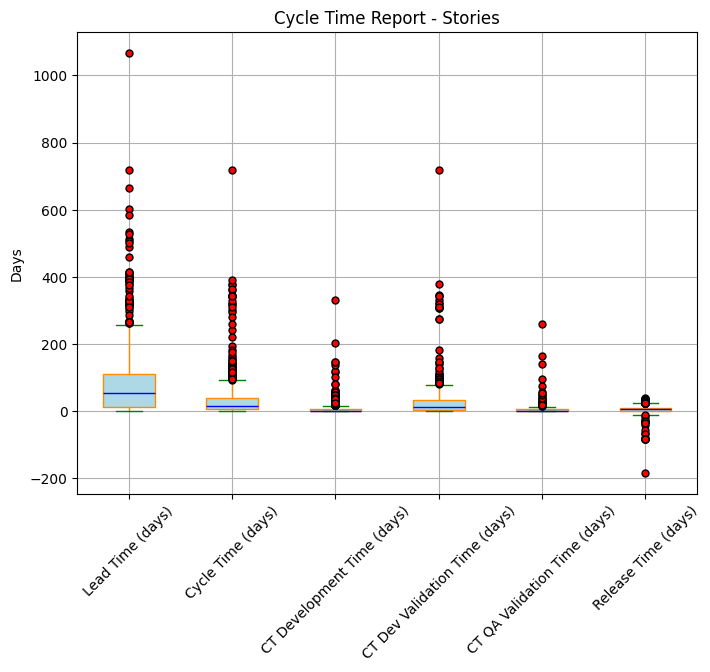

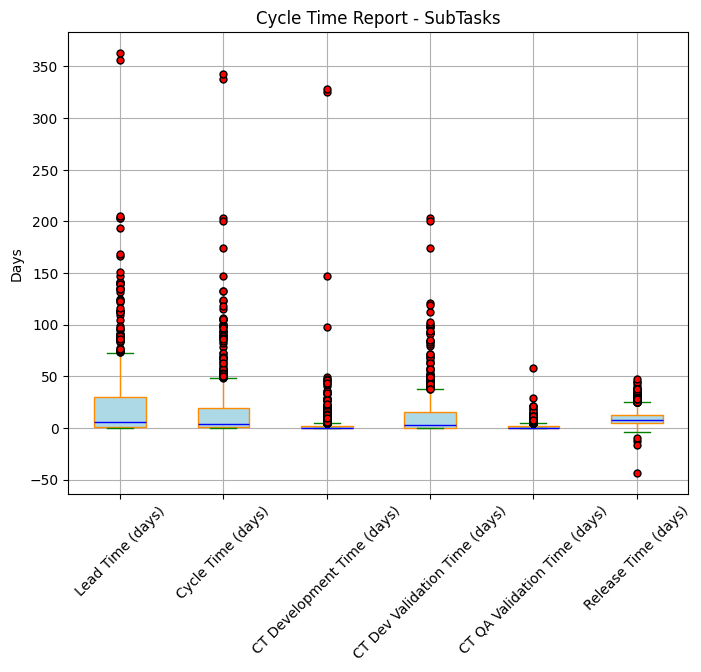

In [96]:
generate_whisker_chart(df_standard_issues, 
                       columns=['Lead Time (days)', 'Cycle Time (days)', 'CT Development Time (days)', 'CT Dev Validation Time (days)', 'CT QA Validation Time (days)', 'Release Time (days)'], 
                       ylabel="Days", title="Cycle Time Report - Stories")
generate_whisker_chart(df_sub_tasks_issues, 
                       columns=['Lead Time (days)', 'Cycle Time (days)', 'CT Development Time (days)', 'CT Dev Validation Time (days)', 'CT QA Validation Time (days)', 'Release Time (days)'], 
                       ylabel="Days", title="Cycle Time Report - SubTasks")

# QUALITY METRICS

Product Catch Rate - # of “Product Acceptance Changes” logged

QA Catch Rate - # of Defects logged

Escape rate - # of Bugs logged

Customer Impact Rate - # of Bugs with Zendesk Ticket Count > 0 

                            Issue Key
Defect Category                      
Customer Impacting Defect          83
Escaped Defect                    130
Feature Work                      612
Internal Identified Defect        460
Support Work                       20


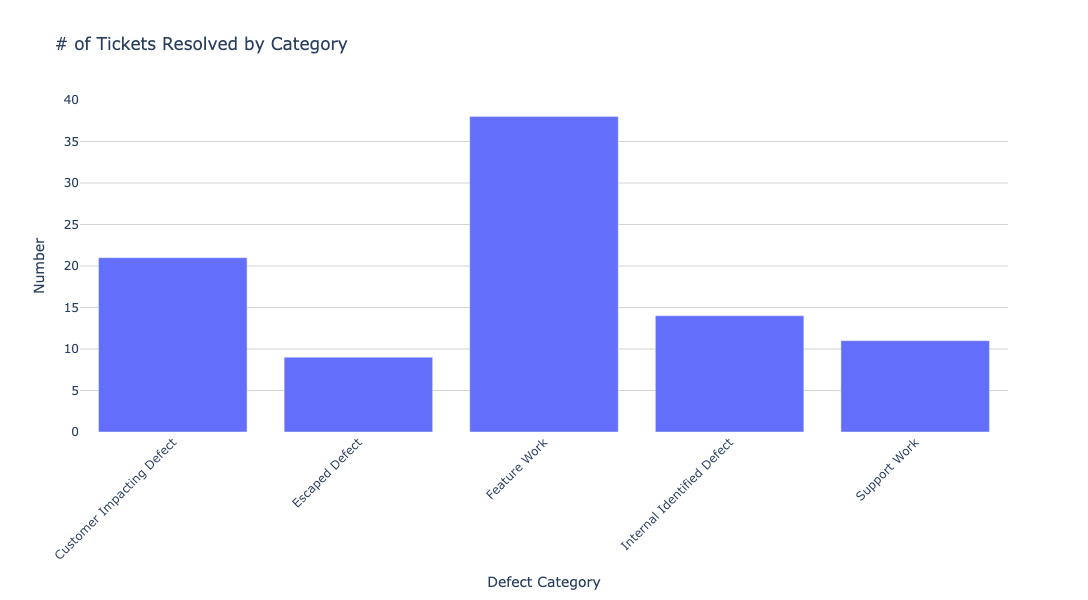

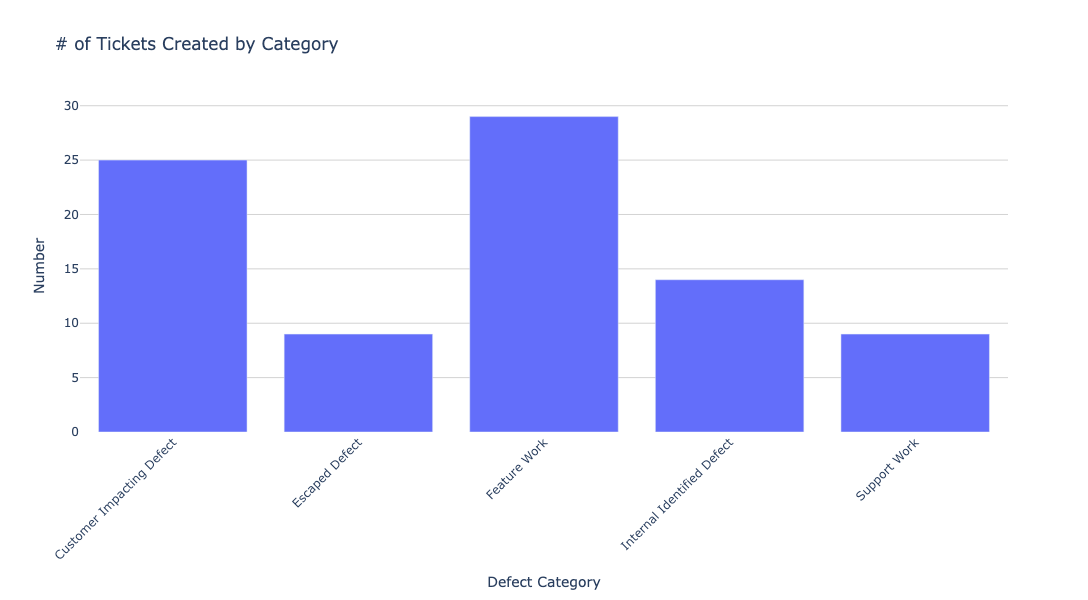

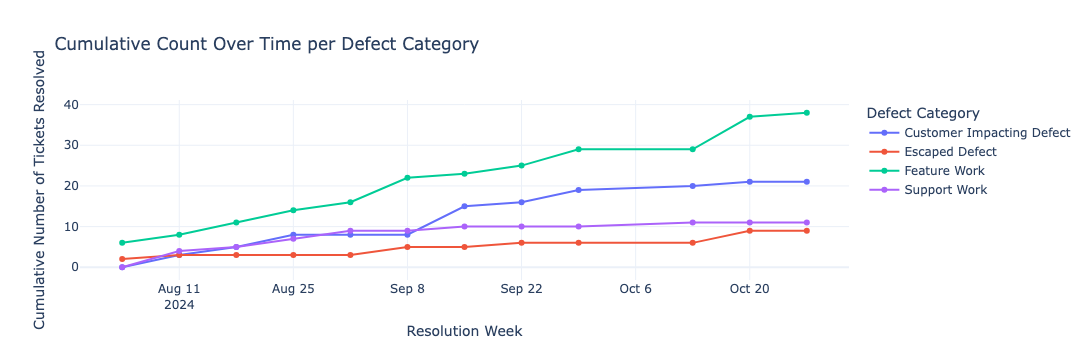

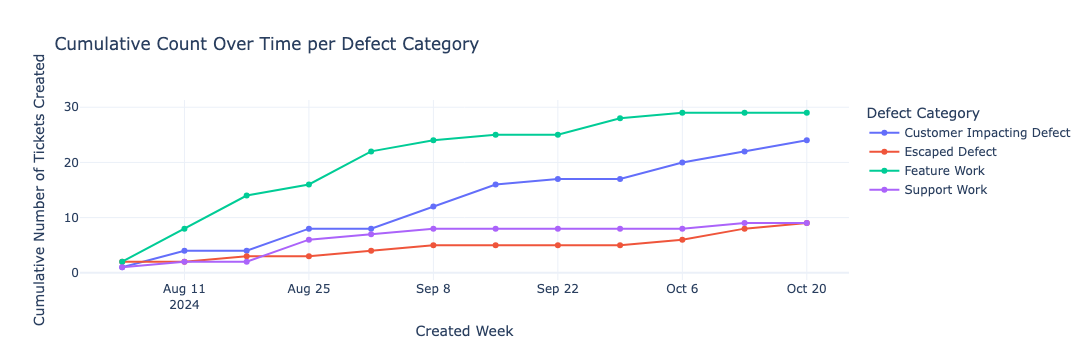

In [97]:
#generate_bar_chart(sub_tasks_analysis,'Defect Percentage Bin',"% of Defect Subtasks")

print(df_all_issues[
    df_all_issues['Defect Category'].notna() & 
    (df_all_issues['Defect Category'].str.strip() != 'Other')].groupby(['Defect Category']).agg({'Issue Key': 'count'}))


generate_bar_chart(df_all_issues_resolved_in_range[
    df_all_issues_resolved_in_range['Defect Category'].notna() & 
    (df_all_issues_resolved_in_range['Defect Category'].str.strip() != 'Other')
],'Defect Category',"# of Tickets Resolved by Category")

generate_bar_chart(df_all_issues_created_in_range[
    df_all_issues_created_in_range['Defect Category'].notna() & 
    (df_all_issues_created_in_range['Defect Category'].str.strip() != 'Other')
],'Defect Category',"# of Tickets Created by Category")

plot_tickets_over_time_interactive(df_standard_issues, top_n=5, start_date=start_date, group_by="Defect Category", date_type="Resolved")
plot_tickets_over_time_interactive(df_standard_issues, top_n=5, start_date=start_date, group_by="Defect Category", date_type="Created")

# THROUGHPUT METRICS

Slope of the trendline: 6.06 per week


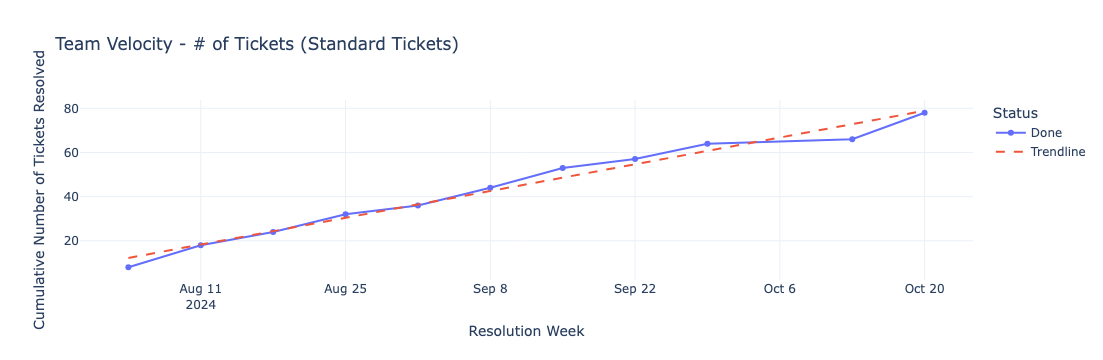

Slope of the trendline: 3.85 per week


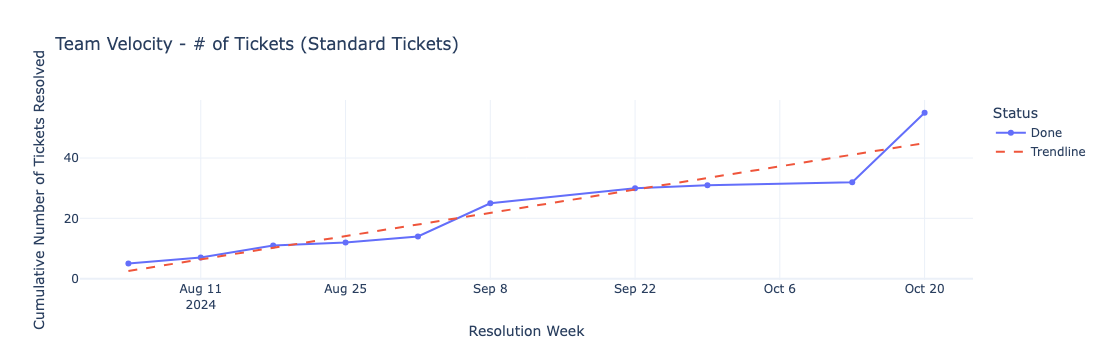

Slope of the trendline: 12.92 per week


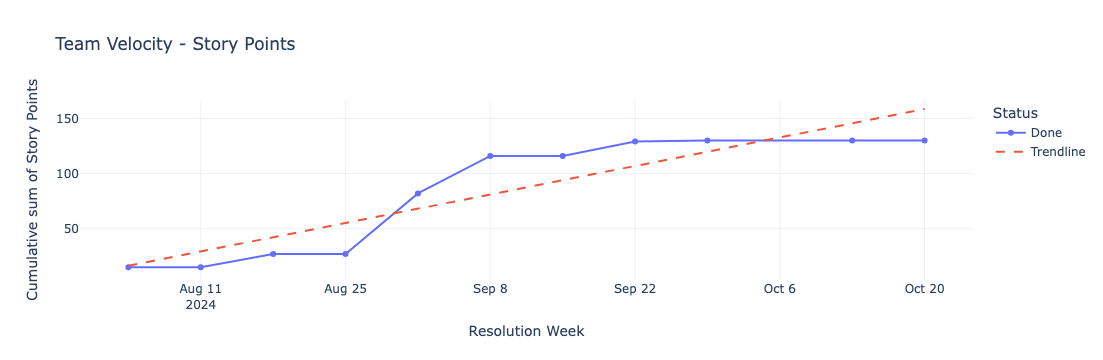

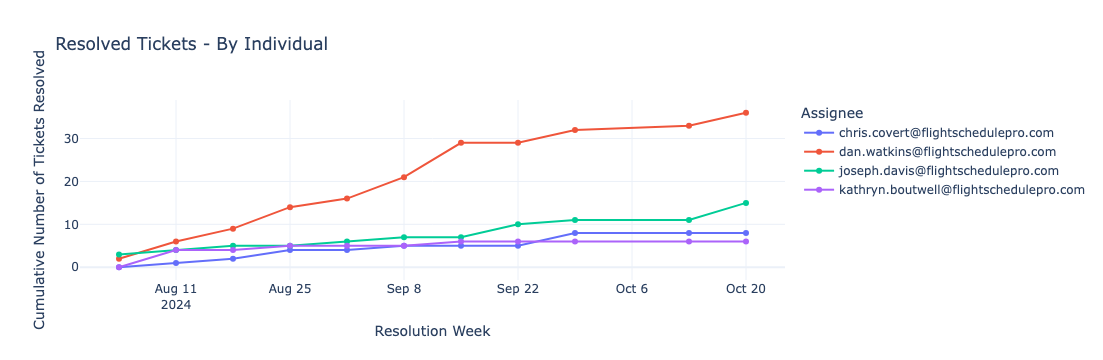

In [99]:
plot_tickets_over_time_interactive(df_standard_issues_resolved_in_range, top_n=1, start_date=start_date, group_by="Status", title="Team Velocity - # of Tickets (Standard Tickets)")
plot_tickets_over_time_interactive(df_sub_tasks_issues_resolved_in_range, top_n=1, start_date=start_date, group_by="Status", title="Team Velocity - # of Tickets (Standard Tickets)")
plot_tickets_over_time_interactive(df_standard_issues_resolved_in_range, top_n=1, start_date=start_date, measure_col="Story Points", aggfunc='sum', group_by="Status", title="Team Velocity - Story Points")
plot_tickets_over_time_interactive(df_standard_issues_resolved_in_range, top_n=4, start_date=start_date, group_by="Assignee", title="Resolved Tickets - By Individual")

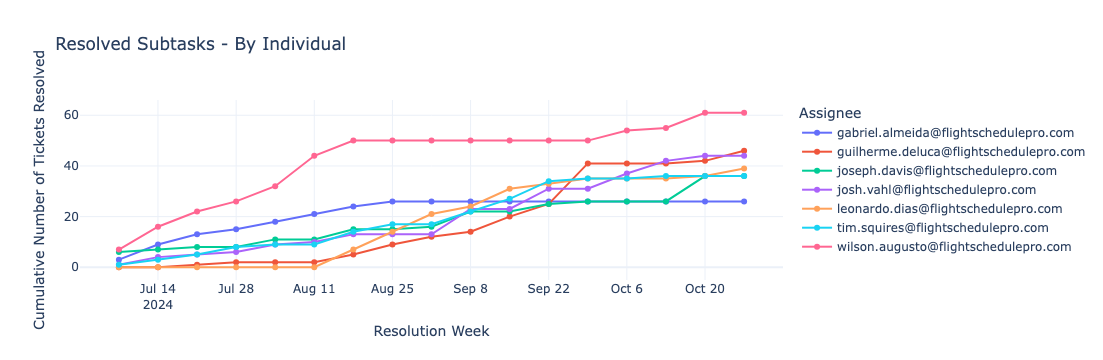

In [46]:
# Subtasks Analysis
plot_tickets_over_time_interactive(df_sub_tasks_issues_resolved_in_range, top_n=7, start_date=start_date, group_by="Assignee", title="Resolved Subtasks - By Individual")


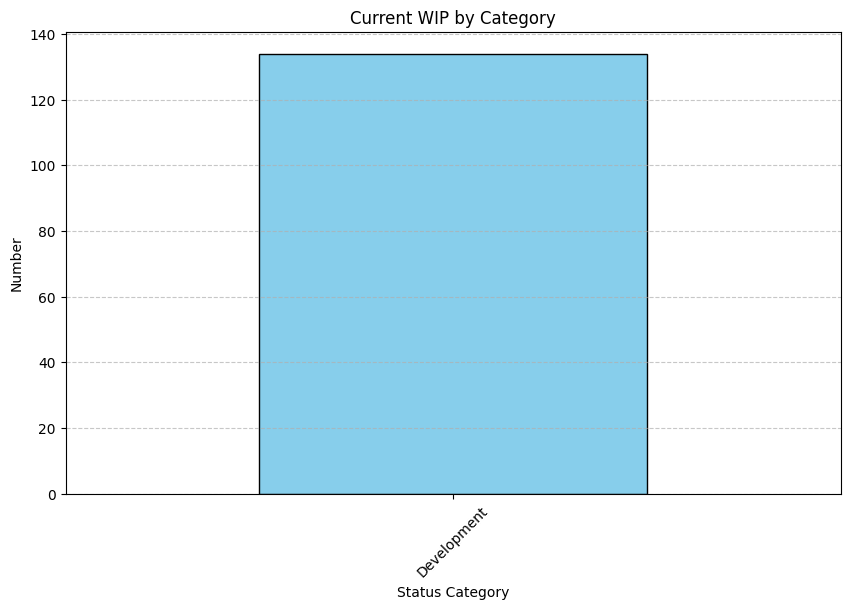

In [47]:
# WIP
generate_bar_chart(df_all_issues[df_all_issues["Status Category"].isin(['Development', 'Validation'])],'Status Category',"Current WIP by Category")

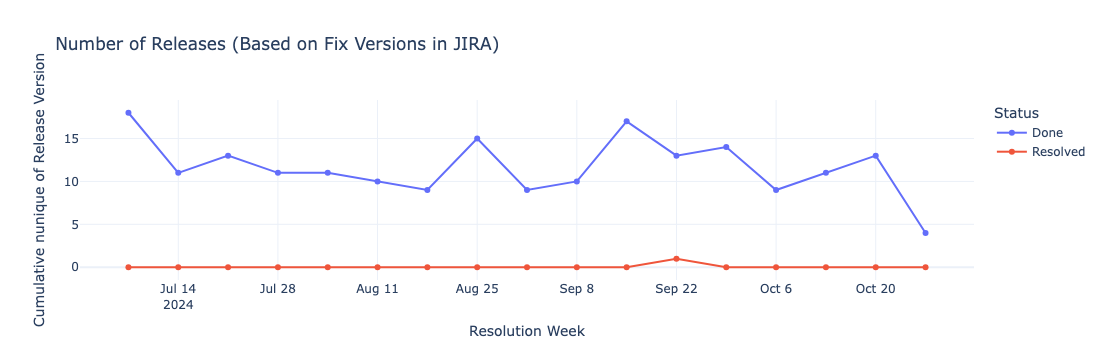

In [48]:
# Release Velocity
plot_tickets_over_time_interactive(df_standard_issues_resolved_in_range, top_n=10, start_date=start_date, measure_col="Release Version", aggfunc='nunique', group_by="Status", title="Number of Releases (Based on Fix Versions in JIRA)", cumulative_agg=False)

In [49]:
#df_sub_tasks_issues[df_sub_tasks_issues['Resolution Week'] >= start_date].groupby(['Issue Type','Assignee']).agg({'Issue Key': 'count'})
df_all_issues_resolved_in_range.to_csv("data.csv")